<h1><center>Sentiment Analysis Model Script</center></h1>

In [12]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from textblob import TextBlob
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

## Functions

#### Functions related to Machine Learning

In [13]:
# Function to perform K-fold Cross Validation.
def perform_cv(df: pd.DataFrame, target: pd.DataFrame, models):
        
    results = []
    mean_fpr = np.linspace(0, 1, 100)
    models_predictions = {}

    for model_alias in models:
    
        print("Model: {}\n".format(model_alias))
        tprs = []
        aucs = []
        thresholds = []
        y_preds = []
        y_preds_prob = []
        y_tests = []
        model = models[model_alias]

        i = 0
        kf = KFold(n_splits=n_folds, random_state=100)
        model_predicted = []
        model_gt = []
    
        for index in kf.split(df):

            print("Fold[{}]\n".format(i+1))
      

            X_train, X_test, y_train, y_test = df.iloc[index[0]], df.iloc[index[1]], target.iloc[index[0]], target.iloc[index[1]]            
            model_fit, y_pred, y_pred_proba = evaluate_model(model, X_train, X_test, y_train, y_test)
            
            print( y_pred_proba)
            print("")
            y_pred = y_pred_proba[:,1] > thresh
            y_pred = y_pred.astype(int)  
            model_predicted = np.concatenate((np.array(model_predicted),y_pred))
            model_gt = np.concatenate((np.array(model_gt),y_test))
            
            generate_performance_stats(y_test, y_pred)                    

            # Compute ROC curve and area the curve
            fpr, tpr, threshold = roc_curve(y_test, y_pred_proba[:,1])
            prec, rec, tre = precision_recall_curve(y_test, y_pred_proba[:,1])
            
            tprs.append(interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
            thresholds.append(threshold)
            
            y_preds = np.append(y_preds, y_pred)
            y_preds_prob = np.append(y_preds_prob, y_pred_proba[:,1])
            y_tests = np.append(y_tests, y_test)
            
            i = i + 1
    
        generate_performance_stats(model_gt, model_predicted)

        result = RESULT(model_alias, tprs, aucs, thresholds, y_preds, y_preds_prob, y_tests)
        results.append(result)
        models_predictions[model_alias] = (model_predicted,model_gt)
        print("########################################################\n")
    
    return results, models_predictions

In [14]:
def sentiment_predict(alg,x_train,y_train,x_cv,y_cv,cols,name):
    
    alg.fit(x_train,y_train)
    predictions = alg.predict(x_cv)
    prob = alg.predict_proba(x_cv)
   
    print(alg)
    print("\nClassification report :\n", classification_report(y_cv,predictions))
       
    
    conf_matrix = confusion_matrix(y_cv,predictions)
    
    acc = accuracy_score(y_cv, predictions)
    prec = precision_score(y_cv, predictions)
    recall = recall_score(y_cv, predictions)
    
    print("Accuracy score:", acc)
    print("Precision score:", prec)
    print("Recall score:", recall)          
    print("Unique predictions:",np.unique( predictions ) )
    
    conf_mat = confusion_matrix(y_true=y_cv, y_pred=predictions)
    
    print('Confusion matrix:\n', conf_mat)
    labels = ['Class 0', 'Class 1']
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Expected')
    plt.ylabel('Predicted')
    plt.show()

#### Functions related to Text Preprocessing - NLP

In [15]:
# Importing SKLearn's list of stopwords 
stop_list = text.ENGLISH_STOP_WORDS

# Text cleaning function
def remove_noise_text(text_input):
    
    # Remove extra whitespaces
    # The apply() function allows to pass a function and apply it on every single value of the series
    text_input = text_input.apply(lambda x: " ".join(x.strip() for x in x.split()))

    # Remove punctuation such as .,;,""
    text_input = text_input.str.replace('[^\w\s]', '')
    
    # Remove numbers
    text_input = text_input.str.replace('\d+', '')
    
    # Remove Stopwords imported from Sklearn
    text_input = text_input.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_list)]))
    
    # Remove special characters
    # The ord() function returns the number representing the unicode of a specified character
    text_input = text_input.apply(lambda x: "".join([" " if ord(i) < 32 or ord(i) > 126 else i for i in x]))
    
    # Convert to string type
    text_input = text_input.astype(str)
        
    return text_input

In [16]:
def sentiment_analyser(text_input):
    return text_input.apply(lambda Text: pd.Series(TextBlob(Text).sentiment.polarity))

 ### 1. File Collection

In [17]:
df = pd.read_csv(r"C:\Users\alinu\Womens Clothing E-Commerce Reviews\Womens Clothing E-Commerce Reviews.csv")

### 2. Data Understanding phase
#### 2.1. Data Description stage

In [18]:
del df["Unnamed: 0"]

In [19]:
df.head(5)

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [20]:
df.dtypes

Clothing ID                 int64
Age                         int64
Title                      object
Review Text                object
Rating                      int64
Recommended IND             int64
Positive Feedback Count     int64
Division Name              object
Department Name            object
Class Name                 object
dtype: object

In [21]:
df.shape

(23486, 10)

In [22]:
df_null=df.isnull()
df_null.sum() 

Clothing ID                   0
Age                           0
Title                      3810
Review Text                 845
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                14
Department Name              14
Class Name                   14
dtype: int64

In [23]:
(df.isnull().sum() / len(df))*100

Clothing ID                 0.000000
Age                         0.000000
Title                      16.222430
Review Text                 3.597888
Rating                      0.000000
Recommended IND             0.000000
Positive Feedback Count     0.000000
Division Name               0.059610
Department Name             0.059610
Class Name                  0.059610
dtype: float64

##### •	Perform volumetric analysis on the Review dataset to understand its nature (variable identification, identification of data types)

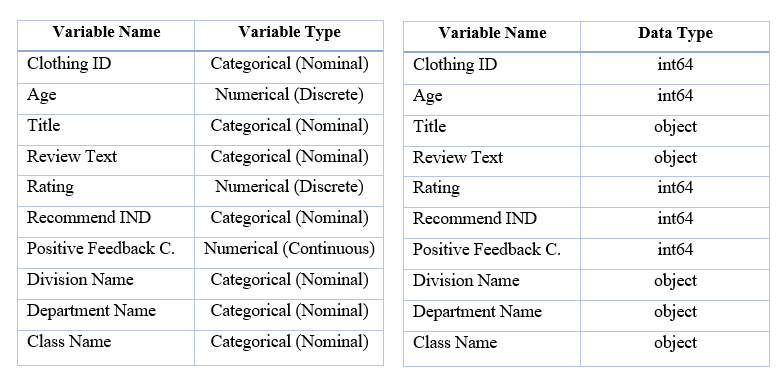

#### 2.2. Data Exploration stage

##### • Handle Missing Values (1)

In [24]:
df.dropna(subset=['Title'], how='all', inplace=True)

In [25]:
df.dropna(subset=['Division Name'], how='all', inplace=True)

In [26]:
df.dropna(subset=['Department Name'], how='all', inplace=True)

In [27]:
df.dropna(subset=['Class Name'], how='all', inplace=True)

In [29]:
df.dropna(subset=['Review Text'], how='all', inplace=True)

In [30]:
df_null=df.isnull()
df_null.sum() 

Clothing ID                0
Age                        0
Title                      0
Review Text                0
Rating                     0
Recommended IND            0
Positive Feedback Count    0
Division Name              0
Department Name            0
Class Name                 0
dtype: int64

##### • Perform Univariate Analysis in order to understand variables one by one in more detail

##### A. Categorical data

#### Clothing ID

In [31]:
df["Clothing ID"].value_counts()
counts = df["Clothing ID"].value_counts()
percent = df["Clothing ID"].value_counts(normalize=True)
percent100 = df["Clothing ID"].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
pd.DataFrame({'Frequency': counts, 'Percentage': percent100})

,Frequency,Percentage
1078,871,4.4%
862,658,3.3%
1094,651,3.3%
1081,487,2.5%
829,452,2.3%
...,...,...
776,1,0.0%
744,1,0.0%
728,1,0.0%
712,1,0.0%


###### Clothing ID is not unique, indicating that there are multiple reviews for a product

#### Title

In [32]:
df["Title"].value_counts()
counts = df["Title"].value_counts()
percent = df["Title"].value_counts(normalize=True)
percent100 = df["Title"].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
pd.DataFrame({'Frequency': counts, 'Percentage': percent100})

,Frequency,Percentage
Love it!,136,0.7%
Beautiful,95,0.5%
Love,88,0.4%
Love!,83,0.4%
Beautiful!,72,0.4%
...,...,...
Perfect every day neutral,1,0.0%
So beautiful! gorgeous orange color!,1,0.0%
Comfortable but not flattering,1,0.0%
Body con,1,0.0%


##### Title is not distinct, suggesting that some reviews have identic titles

#### Review Text

##### Review Text represents the essential feature for building the classifier as it contains the text that needs to be pre-processed and converted so that the algorithms understand it.
##### This variable cannot be analyzed as the written review needs to first be converted to text features – a task which will be performed in the “Data Preparation” phase

#### Recommended IND

In [33]:
df["Recommended IND"].value_counts()
counts = df["Recommended IND"].value_counts()
percent = df["Recommended IND"].value_counts(normalize=True)
percent100 = df["Recommended IND"].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
pd.DataFrame({'Frequency': counts, 'Percentage': percent100})

,Frequency,Percentage
1,16087,81.8%
0,3575,18.2%


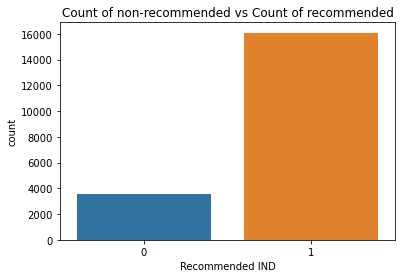

In [34]:
sns.countplot(df['Recommended IND'])
plt.title("Count of non-recommended vs Count of recommended")
plt.show()

##### We can state that this dataset is highly imbalanced as the classes are not represented equally

#### Division Name

In [35]:
df["Division Name"].value_counts()
counts = df["Division Name"].value_counts()
percent = df["Division Name"].value_counts(normalize=True)
percent100 = df["Division Name"].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
pd.DataFrame({'Frequency': counts, 'Percentage': percent100})

,Frequency,Percentage
General,11664,59.3%
General Petite,6778,34.5%
Initmates,1220,6.2%


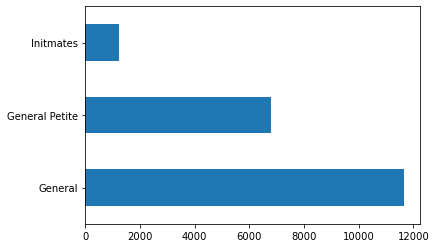

In [36]:
df['Division Name'].value_counts().plot(kind='barh');

##### Regarding Division Name, the General one has the highest number of reviews, followed by General Petite and Initmates

#### Department Name

In [37]:
df["Department Name"].value_counts()
counts = df["Department Name"].value_counts()
percent = df["Department Name"].value_counts(normalize=True)
percent100 = df["Department Name"].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
pd.DataFrame({'Frequency': counts, 'Percentage': percent100})

,Frequency,Percentage
Tops,8713,44.3%
Dresses,5371,27.3%
Bottoms,3184,16.2%
Intimate,1408,7.2%
Jackets,879,4.5%
Trend,107,0.5%


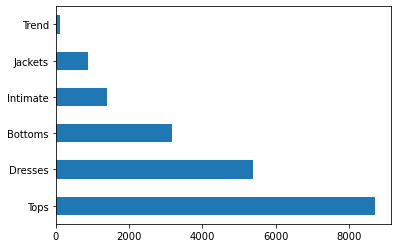

In [38]:
df['Department Name'].value_counts().plot(kind='barh');

##### Concerning Department Name, Tops presents the most reviews whereas Trend has the lowest number of observations

#### Class Name

In [39]:
df["Class Name"].value_counts()
counts = df["Class Name"].value_counts()
percent = df["Class Name"].value_counts(normalize=True)
percent100 = df["Class Name"].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
pd.DataFrame({'Frequency': counts, 'Percentage': percent100})

,Frequency,Percentage
Dresses,5371,27.3%
Knits,3981,20.2%
Blouses,2587,13.2%
Sweaters,1218,6.2%
Pants,1157,5.9%
Jeans,970,4.9%
Fine gauge,927,4.7%
Skirts,796,4.0%
Jackets,598,3.0%
Lounge,574,2.9%


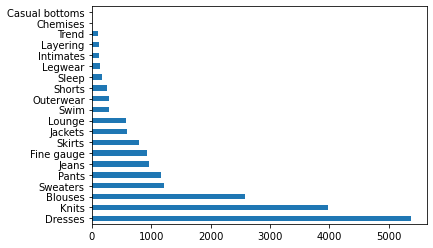

In [40]:
df['Class Name'].value_counts().plot(kind='barh');

#### When it comes to Class Name, the Dresses have the highest frequency

#### Polarity Score -  Creation

#### A new feature was created named Polarity_Score

In [42]:
# Applying function to reviews
df['Polarity_Score'] = sentiment_analyser(df['Review Text'])
df.head(10)

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Polarity_Score
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,0.073675
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,0.550000
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,0.512891
5,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",2,0,4,General,Dresses,Dresses,0.178750
6,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,5,1,1,General Petite,Tops,Knits,0.133750
7,858,39,"Shimmer, surprisingly goes with lots","I ordered this in carbon for store pick up, an...",4,1,4,General Petite,Tops,Knits,0.171635
8,1077,24,Flattering,I love this dress. i usually get an xs but it ...,5,1,0,General,Dresses,Dresses,0.002500
9,1077,34,Such a fun dress!,"I'm 5""5' and 125 lbs. i ordered the s petite t...",5,1,0,General,Dresses,Dresses,0.204200
10,1077,53,Dress looks like it's made of cheap material,Dress runs small esp where the zipper area run...,3,0,14,General,Dresses,Dresses,-0.097149
12,1095,53,Perfect!!!,More and more i find myself reliant on the rev...,5,1,2,General Petite,Dresses,Dresses,0.244156


##### B. Numerical data

#### Polarity Score 

<AxesSubplot:xlabel='Polarity_Score'>

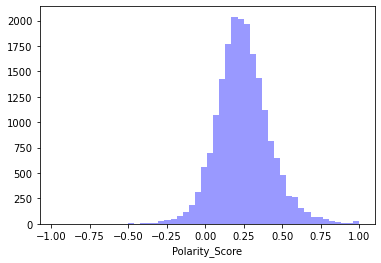

In [43]:
sns.distplot(df['Polarity_Score'], kde=False, color='blue', bins=50)

#### By analyzing the distribution, we can state that the polarity score has an approximate range between 0.18 and 0.26, indicating that most of the customers did indeed express a positive sentiment towards their past purchase.

#### Age

<AxesSubplot:xlabel='Age'>

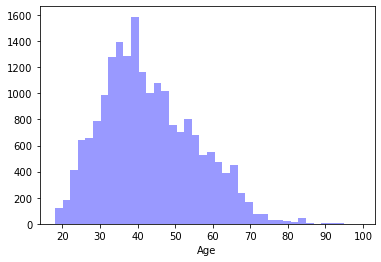

In [44]:
sns.distplot(df['Age'], kde=False, color='blue', bins=40)

#### By analyzing the Age feature, it came to my attention that most customers who provide reviews for products are in their 30s or 40s

#### Rating

<AxesSubplot:xlabel='Rating'>

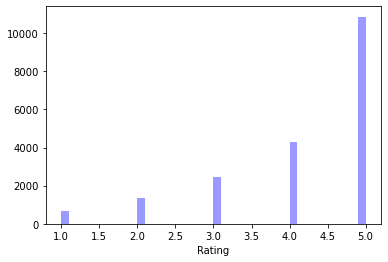

In [45]:
sns.distplot(df['Rating'], kde=False, color='blue', bins=40)

#### Most clients gave high rates of 4 and 5 to their past clothes purchases, confirming that a high number of customers is content with the shop’s products

#### Positive_Feedback_Count

<AxesSubplot:xlabel='Positive Feedback Count'>

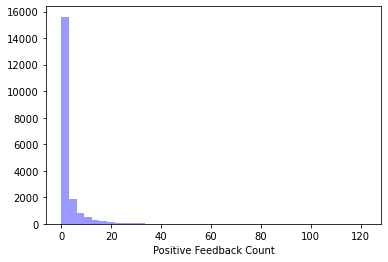

In [46]:
sns.distplot(df['Positive Feedback Count'], kde=False, color='blue', bins=40)

##### Concerning the Positive_Feedback_Count, most clients had a positive feedback count between 0 and 4

#### • Perform Bi-variate Analysis in order to explore the relation of multiple variables 

##### Age_Range Creation

In [47]:
df['AGE_RANGE']=pd.cut(x=df['Age'],bins
=[18,30,40,50,60,70,80,90,100])

In [48]:
df.head(5)

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Polarity_Score,AGE_RANGE
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,0.073675,"(50, 60]"
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,0.550000,"(40, 50]"
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,0.512891,"(40, 50]"
5,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",2,0,4,General,Dresses,Dresses,0.178750,"(40, 50]"
6,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,5,1,1,General Petite,Tops,Knits,0.133750,"(30, 40]"


In [49]:
df['AGE_RANGE'].value_counts()

(30, 40]     6526
(40, 50]     5018
(50, 60]     3270
(18, 30]     2802
(60, 70]     1722
(70, 80]      238
(80, 90]       74
(90, 100]       8
Name: AGE_RANGE, dtype: int64

In [50]:
clients_recommended = df[df['Recommended IND']==1]
clients_not_recommended = df[df['Recommended IND']==0]

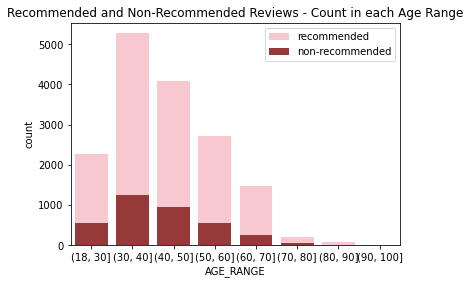

In [51]:
fig = plt.figure(figsize=(13, 9))


plt.subplot2grid((2, 2), (0, 1))
sns.countplot(clients_recommended['AGE_RANGE'],color='pink',alpha=1,label="recommended")
sns.countplot(clients_not_recommended['AGE_RANGE'],color='brown',alpha=1,label="non-recommended")
plt.title("Recommended and Non-Recommended Reviews - Count in each Age Range")
plt.legend(loc='best')

###### By looking at the above figure, we can state that customers in their 30s left the highest number of reviews, followed by customers in their 40s and 50s

In [52]:
recommended_age = clients_recommended[clients_recommended['Age']> 29 ]
not_recommended_age =clients_not_recommended[clients_not_recommended['Age']> 29 ]

In [53]:
recommended_age = clients_recommended[clients_recommended['Age']< 41 ]
not_recommended_age = clients_not_recommended[clients_not_recommended['Age']< 41 ]

In [54]:
recommended_age ['AGE_RANGE']=pd.cut(x=df['Age'],bins
=[30,40])
not_recommended_age ['AGE_RANGE']=pd.cut(x=df['Age'],bins
=[30,40])

In [55]:
not_recommended_age['AGE_RANGE'].value_counts()

(30, 40]    1248
Name: AGE_RANGE, dtype: int64

In [56]:
recommended_age['AGE_RANGE'].value_counts()

(30, 40]    5278
Name: AGE_RANGE, dtype: int64

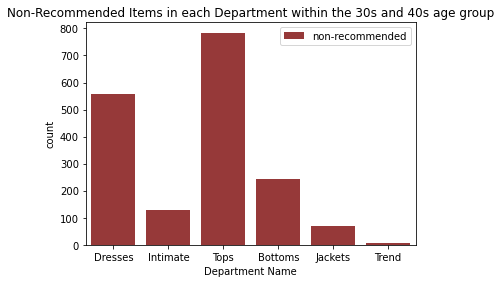

In [57]:
fig = plt.figure(figsize=(13, 9))


plt.subplot2grid((2, 2), (0, 1))

sns.countplot(not_recommended_age['Department Name'],color='brown',alpha=1,label="non-recommended")
plt.title("Non-Recommended Items in each Department within the 30s and 40s age group")
plt.legend(loc='best')

In [58]:
not_recommended_age['Department Name'].value_counts()
counts = not_recommended_age['Department Name'].value_counts()
percent = not_recommended_age['Department Name'].value_counts(normalize=True)
percent100 = not_recommended_age['Department Name'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
pd.DataFrame({'Frequency': counts, 'Percentage': percent100})

,Frequency,Percentage
Tops,783,43.7%
Dresses,558,31.2%
Bottoms,244,13.6%
Intimate,129,7.2%
Jackets,69,3.9%
Trend,8,0.4%


#####  We can clearly observe that the Tops (43.7%) and Dresses (31.2%) departments have the highest number of non-recommendations within the (30,40] age group. Items in the Jackets and Trend departments received the fewest negative reviews. 

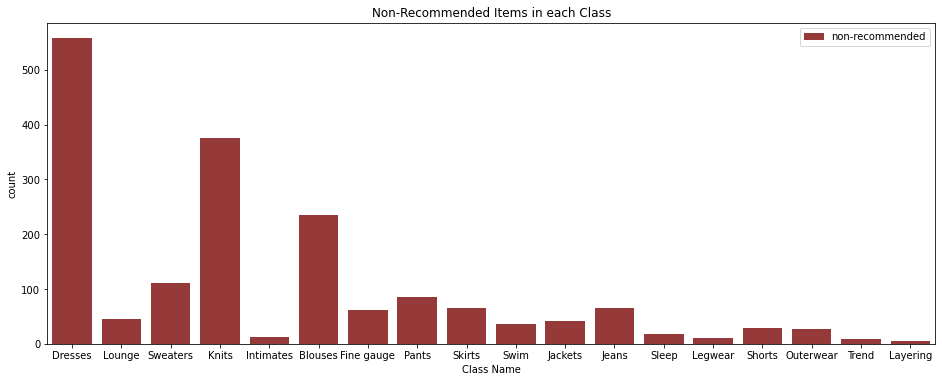

In [59]:
fig = plt.figure(figsize=(35, 13))


plt.subplot2grid((2, 2), (0, 1))

sns.countplot(not_recommended_age['Class Name'],color='brown',alpha=1,label="non-recommended")
plt.title("Non-Recommended Items in each Class")
plt.legend(loc='best')

### 3. Data Preparation phase

In [60]:
df = pd.read_csv(r"C:\Users\alinu\Womens Clothing E-Commerce Reviews\Womens Clothing E-Commerce Reviews.csv")

In [61]:
del df["Unnamed: 0"]

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Clothing ID              23486 non-null  int64 
 1   Age                      23486 non-null  int64 
 2   Title                    19676 non-null  object
 3   Review Text              22641 non-null  object
 4   Rating                   23486 non-null  int64 
 5   Recommended IND          23486 non-null  int64 
 6   Positive Feedback Count  23486 non-null  int64 
 7   Division Name            23472 non-null  object
 8   Department Name          23472 non-null  object
 9   Class Name               23472 non-null  object
dtypes: int64(5), object(5)
memory usage: 1.8+ MB


In [63]:
df['Review Text'].fillna('unknown', inplace=True)

In [64]:
df_null=df.isnull()
df_null.sum() 

Clothing ID                   0
Age                           0
Title                      3810
Review Text                   0
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                14
Department Name              14
Class Name                   14
dtype: int64

In [65]:
# Importing the list of stopwords
stop_list = text.ENGLISH_STOP_WORDS

# Text cleaning function
def remove_noise(text_input):
    
    # Make lowercase
    text_input = text_input.apply(lambda x: " ".join(x.lower() for x in x.split()))
    
    # Remove extra whitespaces
    text_input = text_input.apply(lambda x: " ".join(x.strip() for x in x.split()))
    
    # Remove special characters
    text_input = text_input.apply(lambda x: "".join([" " if ord(i) < 32 or ord(i) > 126 else i for i in x]))
    
    # Remove punctuation
    text_input = text_input.str.replace('[^\w\s]', '')
    
    # Remove numbers
    text_input = text_input.str.replace('\d+', '')
    
    # Remove Stopwords
    text_input = text_input.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_list)]))
    
    # Convert to string
    text_input = text_input.astype(str)
        
    return text_input

In [66]:
# Applying noise removal function to data
df['Cleaned Review Text'] = remove_noise(df['Review Text'])
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Cleaned Review Text
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,absolutely wonderful silky sexy comfortable
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,love dress sooo pretty happened store im glad ...
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,high hopes dress really wanted work initially ...
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,love love love jumpsuit fun flirty fabulous ti...
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,shirt flattering adjustable tie perfect length...


In [67]:
# Instantiate the Word tokenizer & Word lemmatizer
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

# Define the word lemmatizer function
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

# Apply the word lemmatizer function to data
df['Cleaned Review Text'] = df['Cleaned Review Text'].apply(lemmatize_text)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Cleaned Review Text
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,"[absolutely, wonderful, silky, sexy, comfortable]"
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,"[love, dress, sooo, pretty, happened, store, i..."
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,"[high, hope, dress, really, wanted, work, init..."
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,"[love, love, love, jumpsuit, fun, flirty, fabu..."
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,"[shirt, flattering, adjustable, tie, perfect, ..."


In [68]:
# Getting a count of words from the documents - Bag of Words
cvec = CountVectorizer(min_df=.005, max_df=.9, ngram_range=(1,2), tokenizer=lambda doc: doc, lowercase=False)
cvec.fit(df['Cleaned Review Text'])

CountVectorizer(lowercase=False, max_df=0.9, min_df=0.005, ngram_range=(1, 2),
                tokenizer=<function <lambda> at 0x000001438F778670>)

In [69]:
len(cvec.vocabulary_)

886

In [70]:
print(sorted(cvec.vocabulary_))

['able', 'absolutely', 'absolutely love', 'actually', 'add', 'added', 'addition', 'adorable', 'adore', 'ago', 'agree', 'agree reviewer', 'airy', 'aline', 'amazing', 'ankle', 'appears', 'appropriate', 'area', 'arent', 'arm', 'arm hole', 'armhole', 'arrived', 'athletic', 'available', 'away', 'awesome', 'awkward', 'b', 'baby', 'bad', 'bag', 'baggy', 'band', 'barely', 'based', 'based review', 'basic', 'bc', 'beach', 'beautiful', 'beautiful color', 'beautiful dress', 'beautifully', 'believe', 'belly', 'belt', 'best', 'better', 'better person', 'big', 'bigger', 'bit', 'bit large', 'black', 'blazer', 'blouse', 'blue', 'blue color', 'bodice', 'body', 'body type', 'boot', 'booty', 'bottom', 'bought', 'bought dress', 'bought size', 'boxy', 'bra', 'brand', 'bright', 'broad', 'broad shoulder', 'brown', 'build', 'bulky', 'bust', 'busty', 'butt', 'button', 'buy', 'buying', 'c', 'came', 'cami', 'cami underneath', 'camisole', 'cardigan', 'care', 'case', 'casual', 'caught', 'chance', 'cheap', 'chest', 

In [71]:
# Creating the bag-of-words representation
cvec_counts = cvec.transform(df['Cleaned Review Text'])

In [72]:
print(cvec_counts.shape)
print(cvec_counts.toarray())

(23486, 886)
[[0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 1]
 ...
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [73]:
# Instantiating the TfidfTransformer
transformer = TfidfTransformer()

# Transforming
transformed_weights = transformer.fit_transform(cvec_counts)
transformed_weights

<23486x886 sparse matrix of type '<class 'numpy.float64'>'
	with 473238 stored elements in Compressed Sparse Row format>

In [74]:
# Getting a list of all weights
transformed_weights = transformed_weights.toarray()
vocab = cvec.get_feature_names()

# Putting weights into a DataFrame called model
model = pd.DataFrame(transformed_weights, columns=vocab)

model.head(10)

,able,absolutely,absolutely love,actually,add,added,addition,adorable,adore,ago,...,x s,xl,xx,year,yellow,yes,yesterday,youre,zip,zipper
0,0.0,0.384864,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.178346,0.156682
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
5,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
6,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
7,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.208769,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
8,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
9,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.178684,0.000000,0.000000


In [75]:
# Merging td-idf weight model with original df dataFrame
model = pd.merge(df, model, left_index=True, right_index=True)

In [77]:
model.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,...,x s,xl,xx,year,yellow,yes,yesterday,youre,zip,zipper
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.178346,0.156682
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000


In [79]:
# Drop all columns not part of the text matrix
ml_model = model.drop(['Review Text', 'Cleaned Review Text','Clothing ID','Age','Title','Rating','Positive Feedback Count','Division Name','Department Name','Class Name'], axis=1)

# Create X & y variables 

y = ml_model['Recommended IND']

X = ml_model.drop('Recommended IND', axis=1)

# split the data into test and train by maintaining same distribution of output varaible 'Y' [stratify=Y]
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y,test_size=0.15,random_state=1)

# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.15,random_state=1)

In [80]:
X

,able,absolutely,absolutely love,actually,add,added,addition,adorable,adore,ago,...,x s,xl,xx,year,yellow,yes,yesterday,youre,zip,zipper
0,0.000000,0.384864,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.178346,0.156682
3,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
4,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23481,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
23482,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
23483,0.334141,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
23484,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000


In [81]:
y

0        1
1        1
2        0
3        1
4        1
        ..
23481    1
23482    1
23483    0
23484    1
23485    1
Name: Recommended IND, Length: 23486, dtype: int64

### 4. Modelling phase

##### A. Random forest

In [82]:
rf= RandomForestClassifier(n_estimators=200, class_weight='balanced').fit(X_train, y_train)

In [83]:
from sklearn.metrics import roc_curve

# predict probabilities
pred_prob2d = rf.predict_proba(X_cv)

#roc for model
fpr2d, tpr2d, thresh2d = roc_curve(y_cv,pred_prob2d[:,1], pos_label=1)

#roc curve for tpr=fpr
random_probs = [0 for i in range(len(y_cv))]
p_fpr, p_tpr, _ = roc_curve(y_cv, random_probs, pos_label=1)

auc_score2d = roc_auc_score(y_cv, pred_prob2d[:,1])

print(auc_score2d)

0.8945380350999301


RandomForestClassifier(class_weight='balanced', n_estimators=200)

Classification report :
               precision    recall  f1-score   support

           0       0.75      0.41      0.53       532
           1       0.88      0.97      0.93      2463

    accuracy                           0.87      2995
   macro avg       0.82      0.69      0.73      2995
weighted avg       0.86      0.87      0.85      2995

Accuracy score: 0.8707846410684474
Precision score: 0.8835920177383592
Recall score: 0.9707673568818515
Unique predictions: [0 1]
Confusion matrix:
 [[ 217  315]
 [  72 2391]]


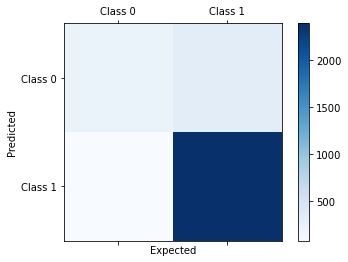

In [84]:
sentiment_predict(rf,X_train,y_train,X_cv,y_cv,y,"RF")

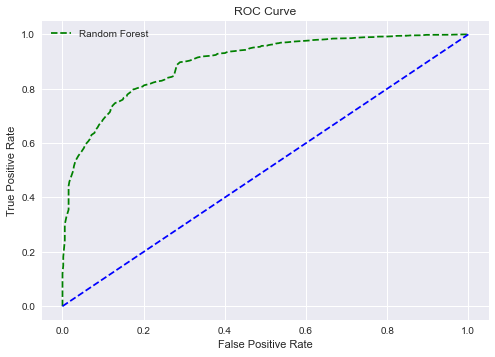

In [85]:
import matplotlib.pyplot as plt
plt.style.use ('seaborn')

#plot rox curves

plt.plot(fpr2d, tpr2d, linestyle='--', color='green', label='Random Forest' )

plt.plot(p_fpr, p_tpr, linestyle='--', color='blue' )

#title
plt.title('ROC Curve')

# X label
plt.xlabel('False Positive Rate')

# Y label
plt.ylabel('True Positive Rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show()

### Cross Validation KFold Random Forest 

In [86]:
# prepare the cross-validation procedure
cv = KFold(n_splits=10, random_state=None)

In [87]:
scores2 = cross_val_score(rf, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
scores2

array([0.89499811, 0.900434  , 0.88047498, 0.9065182 , 0.90253516,
       0.87854598, 0.8833874 , 0.88499139, 0.90435293, 0.88930537])

In [88]:
# report performance
print('AUC Performance: %.3f (%.3f)' % (mean(scores2), std(scores2)))

AUC Performance: 0.893 (0.010)


##### B. Naive Bayes 

In [89]:
gnb = GaussianNB().fit(X_train, y_train)

In [90]:
from sklearn.metrics import roc_curve

# predict probabilities
pred_prob2e = gnb.predict_proba(X_cv)

#roc for model
fpr2e, tpr2e, thresh2e = roc_curve(y_cv,pred_prob2e[:,1], pos_label=1)

#roc curve for tpr=fpr
random_probs = [0 for i in range(len(y_cv))]
p_fpr, p_tpr, _ = roc_curve(y_cv, random_probs, pos_label=1)

auc_score2e = roc_auc_score(y_cv, pred_prob2e[:,1])

print(auc_score2e)

0.8542069241312783


GaussianNB()

Classification report :
               precision    recall  f1-score   support

           0       0.38      0.87      0.53       532
           1       0.96      0.70      0.81      2463

    accuracy                           0.73      2995
   macro avg       0.67      0.78      0.67      2995
weighted avg       0.86      0.73      0.76      2995

Accuracy score: 0.7275459098497495
Precision score: 0.9608282036933408
Recall score: 0.6971173365814048
Unique predictions: [0 1]
Confusion matrix:
 [[ 462   70]
 [ 746 1717]]


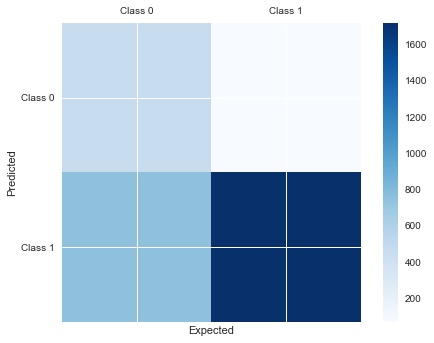

In [91]:
sentiment_predict(gnb,X_train,y_train,X_cv,y_cv,y,"GNB")

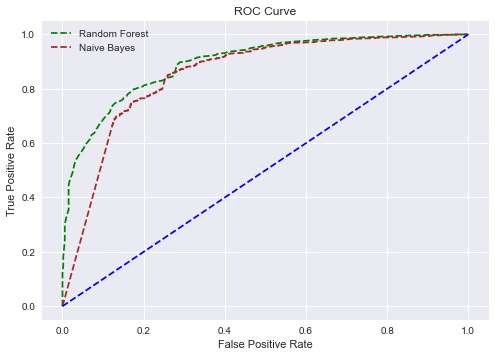

In [92]:
import matplotlib.pyplot as plt
plt.style.use ('seaborn')

#plot rox curves

plt.plot(fpr2d, tpr2d, linestyle='--', color='green', label='Random Forest' )

plt.plot(fpr2e, tpr2e, linestyle='--', color='brown', label='Naive Bayes' )

plt.plot(p_fpr, p_tpr, linestyle='--', color='blue' )

#title
plt.title('ROC Curve')

# X label
plt.xlabel('False Positive Rate')

# Y label
plt.ylabel('True Positive Rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show()

### Cross Validation KFold Naive Bayes

In [93]:
# prepare the cross-validation procedure
cv = KFold(n_splits=10, random_state=None)

In [94]:
scores2 = cross_val_score(gnb, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
scores2

array([0.85088468, 0.84933345, 0.84236856, 0.8473518 , 0.85141578,
       0.83672898, 0.84082704, 0.83529252, 0.84644801, 0.84631891])

In [95]:
# report performance
print('AUC Performance: %.3f (%.3f)' % (mean(scores2), std(scores2)))

AUC Performance: 0.845 (0.005)


### 5. Evaluation phase

### 1. Random Forest Evaluation

RandomForestClassifier(class_weight='balanced', n_estimators=200)

Classification report :
               precision    recall  f1-score   support

           0       0.75      0.40      0.53       626
           1       0.88      0.97      0.93      2897

    accuracy                           0.87      3523
   macro avg       0.82      0.69      0.73      3523
weighted avg       0.86      0.87      0.85      3523

Accuracy score: 0.8705648594947488
Precision score: 0.8829620332601192
Recall score: 0.9713496720745599
Unique predictions: [0 1]
Confusion matrix:
 [[ 253  373]
 [  83 2814]]


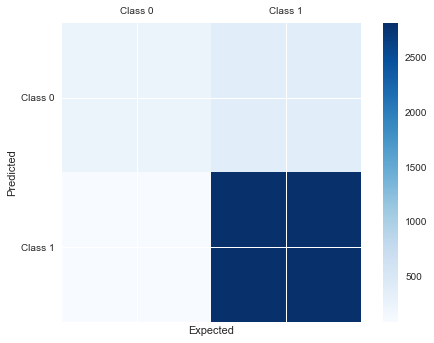

In [96]:
sentiment_predict(rf,X_train,y_train,X_test,y_test,y,"RF")

In [97]:
from sklearn.metrics import roc_curve

# predict probabilities
pred_prob2d_test = rf.predict_proba(X_test)

#roc for model
fpr2d_test, tpr2d_test, thresh2d_test = roc_curve(y_test,pred_prob2d_test[:,1], pos_label=1)

#roc curve for tpr=fpr
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

auc_score2d_test = roc_auc_score(y_test, pred_prob2d_test[:,1])

print(auc_score2d_test)

0.9029843586126884


### 2. Naive Bayes Evaluation

GaussianNB()

Classification report :
               precision    recall  f1-score   support

           0       0.37      0.86      0.52       626
           1       0.96      0.69      0.80      2897

    accuracy                           0.72      3523
   macro avg       0.66      0.77      0.66      3523
weighted avg       0.85      0.72      0.75      3523

Accuracy score: 0.7184217996026114
Precision score: 0.9568345323741008
Recall score: 0.6886434242319641
Unique predictions: [0 1]
Confusion matrix:
 [[ 536   90]
 [ 902 1995]]


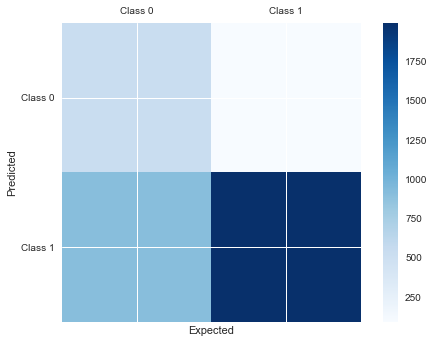

In [98]:
sentiment_predict(gnb,X_train,y_train,X_test,y_test,y,"GNB")

In [99]:
from sklearn.metrics import roc_curve

# predict probabilities
pred_prob2e_test = gnb.predict_proba(X_test)

#roc for model
fpr2e_test, tpr2e_test, thresh2e_test = roc_curve(y_test,pred_prob2e_test[:,1], pos_label=1)

#roc curve for tpr=fpr
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

auc_score2e_test = roc_auc_score(y_test, pred_prob2e_test[:,1])

print(auc_score2e_test)

0.8463966800513034
